In [ ]:
!pip install praw

#Extracting the Data from Reddit

In [ ]:
import praw
import pandas as pd
from datetime import datetime

# -------- Reddit API Credentials --------
reddit = praw.Reddit(
    client_id="KciXO7X8nu-6XJVIAiahIA",
    client_secret="oNJs8-12QYdkNw56-ZqNpXzfuO6KXQ",
    user_agent="Josh"
)

# Subreddits to extract from
subreddits = ["SuicideWatch", "anxiety", "stressed","depressed",]

data = []

for sub in subreddits:
    subreddit = reddit.subreddit(sub)

    for post in subreddit.new(limit=300):
        data.append({
            "community": sub,
            "title": post.title,
            "self_text": post.selftext,
            "date": datetime.fromtimestamp(post.created_utc),
        })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("reddit_emotions_data.csv", index=False)

print("Data extraction complete!")


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Data extraction complete!


# Importing the data

In [ ]:
import pandas as pd
df=pd.read_csv('/content/reddit_emotions_data.csv')

## Data Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079 entries, 0 to 1078
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   community  1079 non-null   object
 1   title      1079 non-null   object
 2   self_text  1039 non-null   object
 3   date       1079 non-null   object
dtypes: object(4)
memory usage: 33.8+ KB


In [ ]:
df=df.dropna()

In [ ]:
df['self_text']=df['self_text'].str.lower()
df['title']=df['title'].str.lower()
df['community']=df['community'].str.lower()

In [ ]:
import re

def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map
        "\U0001F700-\U0001F77F"
        "\U0001F780-\U0001F7FF"
        "\U0001F800-\U0001F8FF"
        "\U0001F900-\U0001F9FF"
        "\U0001FA00-\U0001FAFF"
        "\u2600-\u26FF"
        "\u2700-\u27BF"
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

In [ ]:
df['self_text']=df['self_text'].apply(remove_emojis)
df['title']=df['title'].apply(remove_emojis)

In [ ]:
df.to_csv("processed_emotional_data.csv",index=False)

In [ ]:
df['community'].value_counts()

,count
community,
suicidewatch,300
depressed,300
anxiety,290
stressed,149


In [ ]:
df.head()

,community,title,self_text,date
0,suicidewatch,(17f) im a disgusting deplorable person and i ...,"so im just gonna cut to it, i didnt realise ho...",2026-01-19 11:19:46
1,suicidewatch,i’m feeling like i might end my life,when i was around 12/13 i had a 15/16 year old...,2026-01-19 11:15:17
2,suicidewatch,i'm terrified it won't work,"i've been suffering for a long time, chronic i...",2026-01-19 11:11:33
3,suicidewatch,i can't wait for it to be over.,"m39, i can't wait to die. i am hoping to do it...",2026-01-19 11:09:01
4,suicidewatch,idk what to do,"i feel like shit, i’ve never truly wanted to d...",2026-01-19 11:00:42


# Model Training

In [ ]:
!pip install -q transformers datasets torch scikit-learn emoji accelerate


In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import f1_score


## dataframe to dataset

In [ ]:
dataset = Dataset.from_pandas(df)


In [ ]:
def combine_text(example):
    example["text"] = example["title"] + " " + example["self_text"]
    return example

dataset = dataset.map(combine_text)


Map:   0%|          | 0/1039 [00:00<?, ? examples/s]

## creating labels

In [ ]:
def create_labels(example):
    text = example["text"].lower()
    community = example["community"].lower()

    example["labels"] = [
        float(community == "suicidewatch" or any(k in text for k in [
            "kill myself", "end my life", "suicidal", "don't want to live"
        ])),
        float(community == "depressed"
        ),
        float(community == "anxiety" or any(k in text for k in [
            "anxious", "panic", "fear", "overthinking", "nervous"
        ])),
        float(community == "stressed" or any(k in text for k in [
            "stress", "overwhelmed", "burnout", "pressure", "exhausted"
        ]))
    ]
    return example


dataset = dataset.map(create_labels)


Map:   0%|          | 0/1039 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['community', 'title', 'self_text', 'date', '__index_level_0__', 'text', 'labels'],
    num_rows: 1039
})

In [ ]:
!pip install scikit-multilearn


## Splitting the dataset

In [ ]:
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split

# Convert dataset to arrays
X = np.arange(len(dataset)).reshape(-1, 1)   # indices only
Y = np.array(dataset["labels"])              # multi-label targets

# Stratified 80–20 split
X_train, y_train, X_test, y_test = iterative_train_test_split(
    X, Y, test_size=0.2
)

train_idx = X_train.flatten().astype(int)
test_idx  = X_test.flatten().astype(int)

train_ds = dataset.select(train_idx.tolist())
test_ds  = dataset.select(test_idx.tolist())


In [ ]:
# checking the datasets(training and testing)
train_df = train_ds.to_pandas()
train_counts = train_df["community"].value_counts().sort_index()


test_df = test_ds.to_pandas()
test_counts = test_df["community"].value_counts().sort_index()

proof_df = pd.DataFrame({
    "train_count": train_counts,
    "test_count": test_counts
}).fillna(0).astype(int)

print(proof_df)


NameError: name 'train_ds' is not defined

In [ ]:
#test_df.to_csv('test.csv',index=False)

In [ ]:
#!cp -r test.csv /content/drive/MyDrive/

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding=True,
        truncation=True,
        max_length=256
    )

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/836 [00:00<?, ? examples/s]

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4,
    problem_type="multi_label_classification"
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./distilbert-mental-health-str",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=50,
    do_train=True,
    do_eval=True,
    save_steps=500,
    save_total_limit=2,
    fp16=torch.cuda.is_available()  # GPU acceleration
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# testing accuracyy

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    preds = (probs > 0.4).astype(int)  # slightly lower threshold

    return {
        "f1_weighted": f1_score(labels, preds, average="weighted"),
        "f1_micro": f1_score(labels, preds, average="micro")
    }


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-272691189.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
trainer.train()


Step,Training Loss
50,0.626100
100,0.580600
150,0.506000
200,0.453100
250,0.395300
300,0.395100
350,0.355600
400,0.347900


TrainOutput(global_step=420, training_loss=0.45125242187863307, metrics={'train_runtime': 53.9106, 'train_samples_per_second': 62.029, 'train_steps_per_second': 7.791, 'total_flos': 221493390311424.0, 'train_loss': 0.45125242187863307, 'epoch': 4.0})

In [ ]:
model.save_pretrained("distilbert-mental-health")
tokenizer.save_pretrained("distilbert-mental-health")


('distilbert-mental-health/tokenizer_config.json',
 'distilbert-mental-health/special_tokens_map.json',
 'distilbert-mental-health/vocab.txt',
 'distilbert-mental-health/added_tokens.json',
 'distilbert-mental-health/tokenizer.json')

In [ ]:
import torch

LABEL_NAMES = [
    "suicidal_ideation",
    "depressive_language",
    "anxiety_related",
    "stress_related"
]

def predict(text):
    device = model.device  # cpu or cuda

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True
    )

    #  MOVE INPUTS TO MODEL DEVICE
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits

    probs = torch.sigmoid(logits)[0]

    return {
        LABEL_NAMES[i]: float(probs[i])
        for i in range(len(LABEL_NAMES))
    }


In [ ]:
text = "I feel empty and anxiety I don’t want to live anymore"
print(predict(text))


{'suicidal_ideation': 0.10989668220281601, 'depressive_language': 0.10856642574071884, 'anxiety_related': 0.8887587189674377, 'stress_related': 0.26626187562942505}


In [ ]:
text = "I feel empty and I don’t want to live anymore"
print(predict(text))

{'suicidal_ideation': 0.5240749716758728, 'depressive_language': 0.5556160807609558, 'anxiety_related': 0.07094483077526093, 'stress_related': 0.09534945338964462}


In [ ]:
!cp -r distilbert-mental-health-str /content/drive/MyDrive/


In [ ]:
# Get raw predictions from trainer
pred_output = trainer.predict(test_ds)

logits = pred_output.predictions
true_labels = pred_output.label_ids

# Convert logits → probabilities
probs = 1 / (1 + np.exp(-logits))  # sigmoid

# Threshold (you can tune this later)
y_pred = (probs > 0.5).astype(int)
y_true = true_labels.astype(int)


In [ ]:
LABEL_NAMES = [
    "suicidal_ideation",
    "depressive_language",
    "anxiety_related",
    "stress_related"
]


In [ ]:
from sklearn.metrics import confusion_matrix

for i, label in enumerate(LABEL_NAMES):
    print(f"\nConfusion Matrix for: {label}")
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    print(cm)



Confusion Matrix for: suicidal_ideation
[[125  12]
 [ 23  43]]

Confusion Matrix for: depressive_language
[[127  16]
 [ 30  30]]

Confusion Matrix for: anxiety_related
[[118  12]
 [ 12  61]]

Confusion Matrix for: stress_related
[[137   8]
 [ 32  26]]


In [ ]:
from sklearn.metrics import accuracy_score

subset_accuracy = accuracy_score(y_true, y_pred)
print("Subset Accuracy (strict):", subset_accuracy)


Subset Accuracy (strict): 0.5221674876847291


In [ ]:
from sklearn.metrics import hamming_loss

hamming_acc = 1 - hamming_loss(y_true, y_pred)
print("Hamming Accuracy:", hamming_acc)


Hamming Accuracy: 0.8214285714285714


In [ ]:
from sklearn.metrics import f1_score

print("F1 Micro :", f1_score(y_true, y_pred, average="micro"))
print("F1 Macro :", f1_score(y_true, y_pred, average="macro"))
print("F1 Weighted :", f1_score(y_true, y_pred, average="weighted"))


F1 Micro : 0.6881720430107527
F1 Macro : 0.6694038417906153
F1 Weighted : 0.6795874076096751


In [ ]:
# probs from earlier: shape (N, 4)
# y_true: shape (N, 4)

y_pred_single = probs.argmax(axis=1)
y_true_single = y_true.argmax(axis=1)


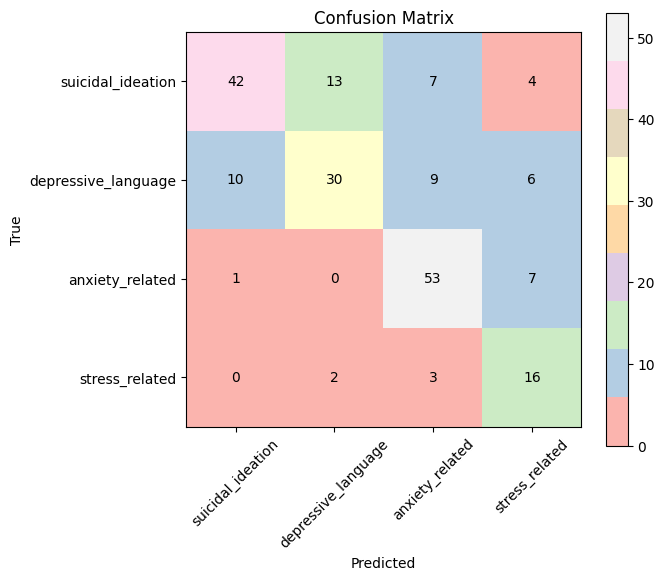

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_single, y_pred_single)

plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Pastel1")
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.yticks(range(len(LABEL_NAMES)), LABEL_NAMES)
plt.xticks(range(len(LABEL_NAMES)), LABEL_NAMES, rotation=45)

for i in range(len(LABEL_NAMES)):
    for j in range(len(LABEL_NAMES)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()
